In [1]:
# Import libraries 
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from copy import deepcopy

from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression 
from sklearn.model_selection import train_test_split, RandomizedSearchCV, KFold
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from utils.utils import *
from sklearn.metrics import classification_report, precision_recall_curve
from imblearn.over_sampling import SMOTE
import joblib

SEED = 123
np.random.seed(SEED)

import warnings
warnings.filterwarnings('ignore')

In [2]:
raw_df = pd.read_csv('../data/raw/cc_fraud.csv')
df = deepcopy(raw_df)

dr_and_amt_features = [col for col in df.columns if 'timestamp' not in col and 'clss' not in col]
len(dr_and_amt_features)

29

## Feature Engineering
1. Rolling average of past n timestamps

In [3]:
# While I'm aware that there are duplicated timestamps, it is unknown what 
# interval are the timestamps. 
# For e.g. 1.0 and 1.0. This could be the same day but morning and afternoon
# In this MVP model, I'll simplify the problem by allowing rolling average
df = df.set_index('timestamp')
window = 30
for feat in dr_and_amt_features:
    df[f'{feat}_rolling_avg_past_{window}_interval'] = df[feat].rolling(window=window).mean()


In [4]:
df_filt = df.dropna(axis=0) #drop the first 30 rows that are null
# export this data, as this will be the input for Variational Autoencoder
df_filt.to_csv('../data/processed/df_w_feat_eng.csv', index=False)
print(df_filt.shape, df.shape)

(284778, 59) (284807, 59)


## Feature Selection

There are many ways to do feature selections. Today, I will be using:

1. Correlation: We to remove features with high correlation with other features so that we can avoid the problem of multicollinearity.
2. Information Value: Information value tells us the predictive power of a feature to separate the two target classes.

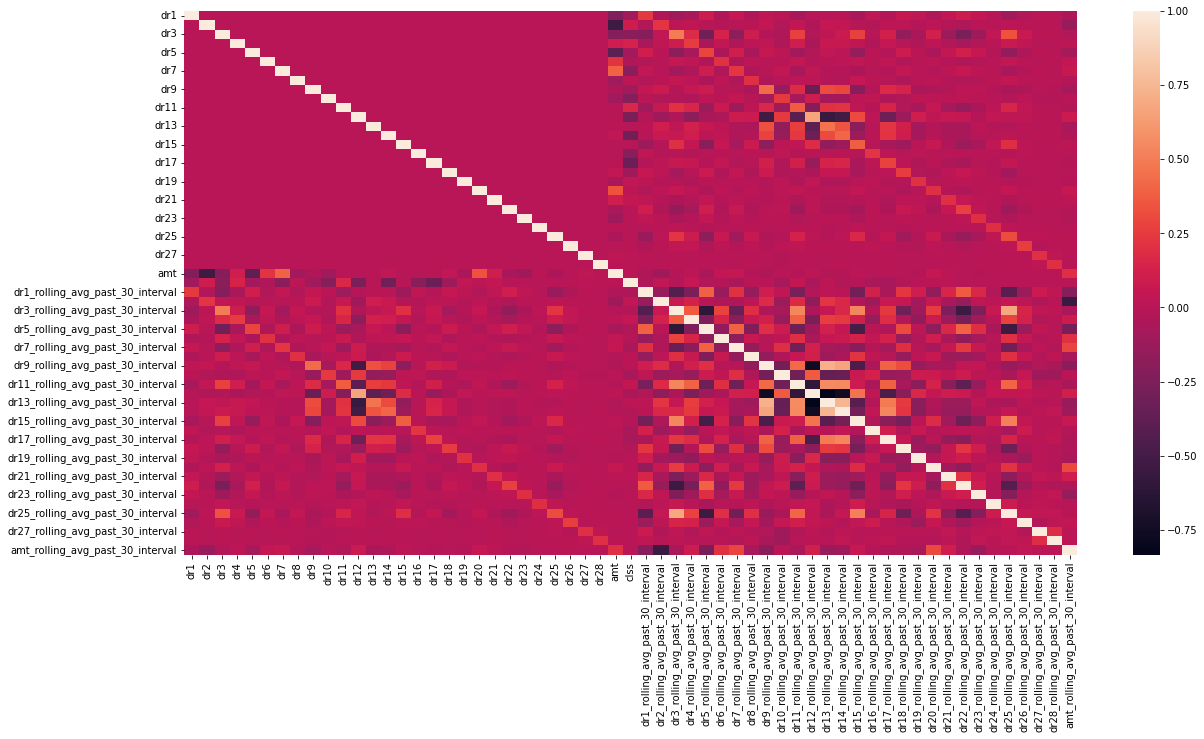

In [5]:
# let's take a look at correlation heat maps
corr_df = df_filt.corr()
fig, ax = plt.subplots(figsize=(20,10))    
sns.heatmap(corr_df);

You can see there are some bright red spots (feature-feature pairwise high correlation). Let's find out which features should be considered for removal.

In [6]:
FEATURE_FEATURE_CORR_THRESHOLD = 0.8
correlated_features = set()
correlation_matrix = corr_df

for i in range(len(correlation_matrix.columns)):
    for j in range(i):
        if abs(correlation_matrix.iloc[i, j]) > FEATURE_FEATURE_CORR_THRESHOLD:
            colname = correlation_matrix.columns[i]
            correlated_features.add(colname)

            
print(correlated_features)

{'dr13_rolling_avg_past_30_interval'}


In [7]:
# remove these columns
df_filt.drop(columns=list(correlated_features), inplace=True)

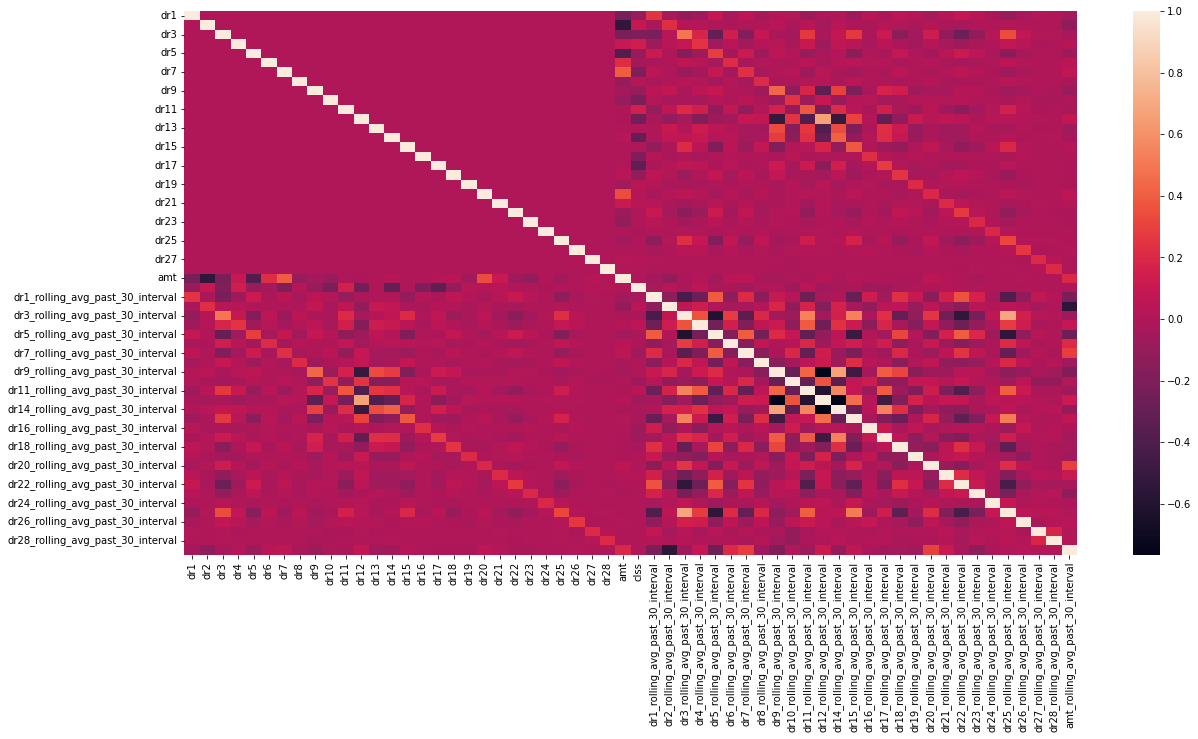

In [8]:
# let's look at the heatmap again
fig, ax = plt.subplots(figsize=(20,10))    
sns.heatmap(df_filt.corr());

This looks better

I also use Information Value concurrently to choose which ones to remove.

In [9]:
TARGET = 'clss'
iv_df, _ = iv_woe(data = df_filt, target = TARGET, bins=10, show_woe = False)
iv_df.sort_values(by="IV", ascending=False, inplace=True)
iv_df

,Variable,IV
0,dr14,3.780025
0,dr4,3.596739
0,dr12,3.210872
0,dr17,3.052120
0,dr10,2.967963
0,dr11,2.869236
0,dr3,2.741566
0,dr16,2.520617
0,dr7,2.273746
0,dr2,2.195322


Select for features with Info value between 0.1 and 1

In [10]:
selected_cols = iv_df.loc[(iv_df['IV'].between(0.1, 1, inclusive=True)), 'Variable'].values.tolist()
selected_cols

['dr20',
 'dr19',
 'dr10_rolling_avg_past_30_interval',
 'dr17_rolling_avg_past_30_interval',
 'amt',
 'dr4_rolling_avg_past_30_interval',
 'dr16_rolling_avg_past_30_interval',
 'dr11_rolling_avg_past_30_interval',
 'dr7_rolling_avg_past_30_interval',
 'dr23',
 'dr1_rolling_avg_past_30_interval',
 'dr2_rolling_avg_past_30_interval',
 'dr9_rolling_avg_past_30_interval',
 'dr3_rolling_avg_past_30_interval',
 'dr15_rolling_avg_past_30_interval',
 'dr5_rolling_avg_past_30_interval',
 'dr18_rolling_avg_past_30_interval',
 'dr8_rolling_avg_past_30_interval',
 'dr26',
 'dr24',
 'dr27_rolling_avg_past_30_interval',
 'dr25']

## Modelling Preparation

### Train test split

In [11]:
selected_cols.append(TARGET)

In [12]:
selected_cols

['dr20',
 'dr19',
 'dr10_rolling_avg_past_30_interval',
 'dr17_rolling_avg_past_30_interval',
 'amt',
 'dr4_rolling_avg_past_30_interval',
 'dr16_rolling_avg_past_30_interval',
 'dr11_rolling_avg_past_30_interval',
 'dr7_rolling_avg_past_30_interval',
 'dr23',
 'dr1_rolling_avg_past_30_interval',
 'dr2_rolling_avg_past_30_interval',
 'dr9_rolling_avg_past_30_interval',
 'dr3_rolling_avg_past_30_interval',
 'dr15_rolling_avg_past_30_interval',
 'dr5_rolling_avg_past_30_interval',
 'dr18_rolling_avg_past_30_interval',
 'dr8_rolling_avg_past_30_interval',
 'dr26',
 'dr24',
 'dr27_rolling_avg_past_30_interval',
 'dr25',
 'clss']

In [13]:
#split data into 80-20 train test. since data is a time series, take first 80% as train set
train_df = df_filt[selected_cols].iloc[:round(len(df_filt)*0.8)]
test_df = df_filt[selected_cols].iloc[round(len(df_filt)*0.8):]
print(train_df.shape, test_df.shape)

(227822, 23) (56956, 23)


In [14]:
X_train_val, X_test, y_train_val, y_test = train_df.drop(columns=TARGET), test_df.drop(columns=TARGET), train_df[TARGET], test_df[TARGET]
print(X_train_val.shape, X_test.shape)
print(y_train_val.shape, y_test.shape)

(227822, 22) (56956, 22)
(227822,) (56956,)


### Oversampling

Because this is a highly imbalanced dataset, we can try doing oversampling.

In [15]:
%%time
smote = SMOTE(random_state=SEED)
X_smote, y_smote = smote.fit_resample(X_train_val, y_train_val)

CPU times: user 394 ms, sys: 645 ms, total: 1.04 s
Wall time: 162 ms


## Modelling



### Baseline Logistic Regression without Oversampling

In [16]:
%%time
# create model object
lr = LogisticRegression(max_iter= 100000)
lr.fit(X_train_val, y_train_val)
lr_pred = lr.predict(X_test)


print("Default Threshold 0.5")
print(classification_report(y_test, lr_pred))
print("Threshold 0.22")
print(classification_report(y_test, lr.predict_proba(X_test)[:,1]>0.22))

Default Threshold 0.5
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56881
           1       0.00      0.00      0.00        75

    accuracy                           1.00     56956
   macro avg       0.50      0.50      0.50     56956
weighted avg       1.00      1.00      1.00     56956

Threshold 0.22
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56881
           1       0.00      0.00      0.00        75

    accuracy                           1.00     56956
   macro avg       0.50      0.50      0.50     56956
weighted avg       1.00      1.00      1.00     56956

CPU times: user 36.1 s, sys: 6.27 s, total: 42.3 s
Wall time: 5.38 s


A simple logistic regression model without oversampling isn't able to predict fraudulent cases. Let's see if we can do any better

### Baseline Logistic Regression with Oversampling

In [17]:
%%time
# create model object
lr_smote = LogisticRegression(max_iter= 100000)
lr_smote.fit(X_smote, y_smote)
lr_smote_pred = lr_smote.predict(X_test)

print("Default Threshold 0.5")
print(classification_report(y_test, lr_smote_pred))
print("Threshold 0.22")
print(classification_report(y_test, lr_smote.predict_proba(X_test)[:,1]>0.22))

Default Threshold 0.5
              precision    recall  f1-score   support

           0       1.00      0.95      0.97     56881
           1       0.01      0.57      0.03        75

    accuracy                           0.95     56956
   macro avg       0.51      0.76      0.50     56956
weighted avg       1.00      0.95      0.97     56956

Threshold 0.22
              precision    recall  f1-score   support

           0       1.00      0.57      0.73     56881
           1       0.00      0.88      0.01        75

    accuracy                           0.57     56956
   macro avg       0.50      0.73      0.37     56956
weighted avg       1.00      0.57      0.73     56956

CPU times: user 1min 26s, sys: 24.5 s, total: 1min 51s
Wall time: 14.5 s


A logistic regression model with oversampling, after tuning threshold is able to get about 0.88 recall but 0 precision. 

At least now we have a baseline. Let's try more complex models.

### Modelling with LightGBM

LightGBM is a very powerful implementation of GBM 

In [18]:
# LGBM hyperparameter randomised gridsearch
lgbm_grid_parameters = {
    "objective" : ['binary'], 
    "learning_rate": [0.001, 0.005, 0.01, 0.025, 0.05, 0.1], # determines the impact of each tree on the final outcome. for better accuracy, i coupled small learning rate with large num of iterations 
    "max_depth":[2, 3], # limit how deep the trees grow to prevent overfitting
    "feature_fraction" : [0.4, 0.5, 0.6, 0.7], #to prevent overfitting, LGBM randomly selects part of features on each iteration (tree) if feature_fraction smaller than 1.0. For example, if you set it to 0.7, LightGBM will select 70% of features before training each tree
    "n_estimators":[100, 200], #num of iterations
    "num_leaves" : [10, 20, 30, 40, 50], # to prevent overfitting, set num_leaf per estimator/tree,
    "min_data_in_leaf":[10], #to prevent overfitting, set a minimum number of data points needed in a child (leaf) node
    "min_split_gain" : [0.5, 0.6, 0.7], #to prevent overfitting, set a minimum loss reduction required to make a further partition on a leaf node of the tree 
    "random_state" : [SEED],
    "importance_type": ['gain']} 

lgbm_reg_finder = RandomizedSearchCV(LGBMClassifier(), lgbm_grid_parameters,
                                 n_jobs=-1, 
                                verbose=-1, # hide warnings
                                 cv = BlockingTimeSeriesSplit(n_splits=5), 
                                n_iter=150,
                                 return_train_score=False, random_state=SEED)

# training and finding the best model using cv
lgbm_reg_finder.fit(X_smote, y_smote, 
                    feature_name = list(X_train_val.columns))

with open('../models/lgbm_smote_model.pkl', 'wb') as to_write:
    joblib.dump(lgbm_reg_finder, to_write)
    


[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.7, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.7
[LightGBM] [Warning] min_data_in_leaf is set=10, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=10
[LightGBM] [Warning] feature_fraction is set=0.5, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.5
[LightGBM] [Warn

RandomizedSearchCV(cv=KFold(n_splits=5, random_state=123, shuffle=True),
                   estimator=LGBMClassifier(), n_iter=150, n_jobs=-1,
                   param_distributions={'feature_fraction': [0.4, 0.5, 0.6,
                                                             0.7],
                                        'importance_type': ['gain'],
                                        'learning_rate': [0.001, 0.005, 0.01,
                                                          0.025, 0.05, 0.1],
                                        'max_depth': [2, 3],
                                        'min_data_in_leaf': [10],
                                        'min_split_gain': [0.5, 0.6, 0.7],
                                        'n_estimators': [100, 200],
                                        'num_leaves': [10, 20, 30, 40, 50],
                                        'objective': ['binary'],
                                        'random_state': [123]},
               

In [19]:
#this returns a dict of the parameter setting that gave the best results on the hold out data
print("Default Threshold 0.5")
print(classification_report(y_test, lgbm_reg_finder.predict(X_test)))

Default Threshold 0.5
              precision    recall  f1-score   support

           0       1.00      0.97      0.98     56881
           1       0.02      0.61      0.05        75

    accuracy                           0.97     56956
   macro avg       0.51      0.79      0.51     56956
weighted avg       1.00      0.97      0.98     56956



In [20]:
# Predict the probabilities and Get the probabilities for positive class
lgbm_reg_finder = joblib.load('../models/lgbm_smote_model.pkl')
lgbm_prob_array = lgbm_reg_finder.predict_proba(X_test)[:,1].round(2)

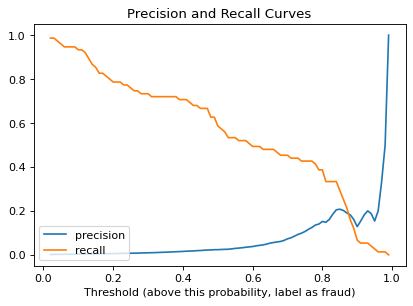

In [21]:
# We can also use the probabilities to make a curve showing us how recall 
# and thresholds trade off 

precision_curve, recall_curve, threshold_curve = precision_recall_curve(y_test, lgbm_prob_array)

plt.figure(dpi=80)
plt.plot(threshold_curve, precision_curve[1:],label='precision')
plt.plot(threshold_curve, recall_curve[1:], label='recall')
plt.legend(loc='lower left')
plt.xlabel('Threshold (above this probability, label as fraud)');
plt.title('Precision and Recall Curves');

Chose a threshold of 0.8 (where probabilities >=0.8 are considered as fraud) by inspecting the precision recall curve above. Threshold of 0.8 is chosen instead of the intersection between precision and recall curve because recall is a more importance metric to prioritise than precision for a fraud detection use case. We'd rather inconvenience customers flagged as False positives, than to incur heavy losses from customers flagged as False negatives. Hence, I chose 0.8 where the recall score is slightly higher, but precision score is not too low.

In [22]:
print("Threshold 0.8")
print(classification_report(y_test, lgbm_prob_array>0.8))

Threshold 0.8
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     56881
           1       0.15      0.39      0.22        75

    accuracy                           1.00     56956
   macro avg       0.58      0.69      0.61     56956
weighted avg       1.00      1.00      1.00     56956



This LGBM model with oversampling has a precision score of 0.15. This means, out of 10 frauds identified by the model, only 1 of them is truly fraudulent. It has a recall score of of around 0.39 tells us that, out of 10 truly fraudulent cases, the model identified close to 4 of them. F1 score (which is a harmonic mean of precision and recall) is 0.22.

Let's see whether a more complex model like Variational Autoencoder (VAE) can perform better. See `03_fraud_detection_vae_main.ipynb`